## SELASTONE LOAN DEFAULT PREDICTION - JUPYTER NOTEBOOK
Using Loan_Default.csv from Kaggle

## Importing the libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import pickle
import json
from pathlib import Path
import warnings
import os
warnings.filterwarnings('ignore')

np.random.seed(42)
sns.set_style("whitegrid")
print("✓ All imports successful")

✓ All imports successful


## Importing the dataset

In [3]:
csv_path = r"C:\Users\user\Documents\dev\selastone_loan_default\archive"

df = pd.read_csv(os.path.join(csv_path, 'Loan_Default.csv'))
print(f"✓ Data loaded: {df.shape}")
print(f"\nDataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"\nFirst rows:")
print(df.head())

✓ Data loaded: (148670, 34)

Dataset shape: 148,670 rows × 34 columns

First rows:
      ID  year loan_limit             Gender approv_in_adv loan_type  \
0  24890  2019         cf  Sex Not Available         nopre     type1   
1  24891  2019         cf               Male         nopre     type2   
2  24892  2019         cf               Male           pre     type1   
3  24893  2019         cf               Male         nopre     type1   
4  24894  2019         cf              Joint           pre     type1   

  loan_purpose Credit_Worthiness open_credit business_or_commercial  ...  \
0           p1                l1        nopc                  nob/c  ...   
1           p1                l1        nopc                    b/c  ...   
2           p1                l1        nopc                  nob/c  ...   
3           p4                l1        nopc                  nob/c  ...   
4           p1                l1        nopc                  nob/c  ...   

   credit_type  Credit_Scor

## EXPLORE & CLEAN

In [4]:
print("\n" + "="*70)
print("DATA EXPLORATION & CLEANING")
print("="*70)

# Check target variable
print(f"\nTarget Variable (Status):")
print(df['Status'].value_counts())
print(f"Default Rate: {df['Status'].mean():.2%}")

# Remove ID column (not a feature)
df = df.drop(['ID'], axis=1)

# Missing values
print(f"\nMissing Values Summary:")
missing_pct = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
print(missing_pct[missing_pct > 0].head(15))

# Drop columns with >40% missing
drop_cols = missing_pct[missing_pct > 40].index.tolist()
print(f"\nDropping {len(drop_cols)} columns with >40% missing:")
print(drop_cols)
df = df.drop(columns=drop_cols)

print(f"\nDataset shape after cleaning: {df.shape}")


DATA EXPLORATION & CLEANING

Target Variable (Status):
Status
0    112031
1     36639
Name: count, dtype: int64
Default Rate: 24.64%

Missing Values Summary:
Upfront_charges              26.664425
Interest_rate_spread         24.644515
rate_of_interest             24.509989
dtir1                        16.224524
LTV                          10.155378
property_value               10.155378
income                        6.154571
loan_limit                    2.249277
approv_in_adv                 0.610749
submission_of_application     0.134526
age                           0.134526
loan_purpose                  0.090133
Neg_ammortization             0.081388
term                          0.027578
dtype: float64

Dropping 0 columns with >40% missing:
[]

Dataset shape after cleaning: (148670, 33)


## FEATURE ENGINEERING

In [5]:
print("\n" + "="*70)
print("FEATURE ENGINEERING")
print("="*70)

# Extract numeric and categorical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Remove target from features
if 'Status' in numeric_cols:
    numeric_cols.remove('Status')

print(f"Numeric columns ({len(numeric_cols)}): {numeric_cols}")
print(f"\nCategorical columns ({len(categorical_cols)}): {categorical_cols}")

# Fill missing numeric values with median
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

# Fill missing categorical values with mode
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)

print(f"\n✓ Missing values filled")

# Create derived features
df['loan_to_income'] = df['loan_amount'] / (df['income'] + 1)
df['loan_to_property'] = df['loan_amount'] / (df['property_value'] + 1)
df['credit_to_income'] = df['Credit_Score'] / (df['income'] + 1)

# Add new features to numeric columns
new_features = ['loan_to_income', 'loan_to_property', 'credit_to_income']
numeric_cols.extend(new_features)

print(f"✓ Created {len(new_features)} derived features")
print(f"✓ Total numeric features: {len(numeric_cols)}")


FEATURE ENGINEERING
Numeric columns (11): ['year', 'loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term', 'property_value', 'income', 'Credit_Score', 'LTV', 'dtir1']

Categorical columns (21): ['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'open_credit', 'business_or_commercial', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'construction_type', 'occupancy_type', 'Secured_by', 'total_units', 'credit_type', 'co-applicant_credit_type', 'age', 'submission_of_application', 'Region', 'Security_Type']

✓ Missing values filled
✓ Created 3 derived features
✓ Total numeric features: 14


## PREPARE FEATURES FOR MODELING

In [6]:
print("\n" + "="*70)
print("PREPARE FEATURES")
print("="*70)

# Separate X and y
X = df[numeric_cols + categorical_cols].copy()
y = df['Status'].copy()

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target distribution:")
print(f"  0 (No Default): {(y == 0).sum():,}")
print(f"  1 (Default): {(y == 1).sum():,}")

# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

print(f"✓ Encoded {len(categorical_cols)} categorical columns")

# Handle outliers (clip at 1st and 99th percentiles)
for col in numeric_cols:
    q1 = X[col].quantile(0.01)
    q99 = X[col].quantile(0.99)
    X[col] = X[col].clip(q1, q99)

print(f"✓ Handled outliers")
print(f"\nFinal features: {X.columns.tolist()}")


PREPARE FEATURES
Features shape: (148670, 35)
Target shape: (148670,)
Target distribution:
  0 (No Default): 112,031
  1 (Default): 36,639
✓ Encoded 21 categorical columns
✓ Handled outliers

Final features: ['year', 'loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term', 'property_value', 'income', 'Credit_Score', 'LTV', 'dtir1', 'loan_to_income', 'loan_to_property', 'credit_to_income', 'loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'open_credit', 'business_or_commercial', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'construction_type', 'occupancy_type', 'Secured_by', 'total_units', 'credit_type', 'co-applicant_credit_type', 'age', 'submission_of_application', 'Region', 'Security_Type']


## TRAIN-TEST SPLIT

In [7]:
print("\n" + "="*70)
print("TRAIN-TEST SPLIT")
print("="*70)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"  Default rate: {y_train.mean():.2%}")
print(f"\nTest set: {X_test.shape}")
print(f"  Default rate: {y_test.mean():.2%}")

feature_names = X.columns.tolist()


TRAIN-TEST SPLIT
Training set: (118936, 35)
  Default rate: 24.64%

Test set: (29734, 35)
  Default rate: 24.65%


## SCALE FEATURES

In [8]:
print("\n" + "="*70)
print("SCALE FEATURES")
print("="*70)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✓ Features scaled (mean=0, std=1)")
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")


SCALE FEATURES


✓ Features scaled (mean=0, std=1)
Training set shape: (118936, 35)
Test set shape: (29734, 35)


## HANDLE CLASS IMBALANCE

In [9]:
print("\n" + "="*70)
print("HANDLE CLASS IMBALANCE (SMOTE)")
print("="*70)

# smote = SMOTE(random_state=42, k_neighbors=5)
smote = SMOTE(
    k_neighbors=3,        # Default is 5, try 3 for sparse regions
    sampling_strategy=0.8, # 0.8 instead of 1.0 (keep some imbalance)
    random_state=42
)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"Before SMOTE:")
print(f"  Shape: {X_train_scaled.shape}")
print(f"  Defaults: {y_train.sum():,} ({y_train.mean():.2%})")

print(f"\nAfter SMOTE:")
print(f"  Shape: {X_train_balanced.shape}")
print(f"  Defaults: {y_train_balanced.sum():,} ({y_train_balanced.mean():.2%})")


HANDLE CLASS IMBALANCE (SMOTE)
Before SMOTE:
  Shape: (118936, 35)
  Defaults: 29,311 (24.64%)

After SMOTE:
  Shape: (161325, 35)
  Defaults: 71,700 (44.44%)


## TRAIN XGBOOST

In [10]:
print("\n" + "="*70)
print("TRAIN XGBOOST MODEL")
print("="*70)

# Calculate scale_pos_weight for imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.03,
    subsample=0.7,
    colsample_bytree=0.7,
    min_child_weight=3,         # Added → prevents shallow splits
    reg_lambda=1.0,             # Added → L2 regularization
    reg_alpha=0.5,              # Added → L1 regularization
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss',
    verbosity=0
)

print(f"Training XGBoost with scale_pos_weight={scale_pos_weight:.2f}...")
xgb_model.fit(X_train_balanced, y_train_balanced)

print(f"✓ XGBoost model trained")
print(f"  Trees: {xgb_model.n_estimators}")
print(f"  Max depth: {xgb_model.max_depth}")


TRAIN XGBOOST MODEL
Training XGBoost with scale_pos_weight=3.06...
✓ XGBoost model trained
  Trees: 500
  Max depth: 4


## EVALUATE XGBOOST MODEL

In [11]:
print("\n" + "="*70)
print("MODEL EVALUATION")
print("="*70)

# ========== TRAINING PREDICTIONS ==========
# Binary predictions (0 or 1) for training set
y_train_pred = xgb_model.predict(X_train_scaled)
# Probability scores for positive class (used for AUC-ROC)
y_train_pred_proba = xgb_model.predict_proba(X_train_scaled)[:, 1]

# ========== TEST PREDICTIONS ==========
# Binary predictions (0 or 1) for test set (unseen data)
y_test_pred = xgb_model.predict(X_test_scaled)
# Probability scores for positive class on test set
y_test_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

# ========== CALCULATE METRICS ==========
# Accuracy: % of correct predictions (0-1 scale)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# F1-Score: Harmonic mean of precision & recall (best for imbalanced data)
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

# AUC-ROC: Area under curve (0.5=random, 1.0=perfect)
train_auc = roc_auc_score(y_train, y_train_pred_proba)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

# ========== TRAINING METRICS ==========
print("Training Metrics:")
print(f"  Accuracy: {train_accuracy:.4f}")
print(f"  F1-Score: {train_f1:.4f}")
print(f"  AUC-ROC:  {train_auc:.4f}")

# ========== TEST METRICS (Most Important) ==========
print("\nTest Metrics:")
print(f"  Accuracy: {test_accuracy:.4f}")
print(f"  F1-Score: {test_f1:.4f}")
print(f"  AUC-ROC:  {test_auc:.4f}")

# ========== CONFUSION MATRIX ==========
# Breakdown of correct/incorrect predictions
cm = confusion_matrix(y_test, y_test_pred)

print(f"\nConfusion Matrix:")
print(f"  True Negatives:  {cm[0,0]:,}   # Correctly predicted negative")
print(f"  False Positives: {cm[0,1]:,}   # Incorrectly predicted positive")
print(f"  False Negatives: {cm[1,0]:,}   # Incorrectly predicted negative (missed cases)")
print(f"  True Positives:  {cm[1,1]:,}   # Correctly predicted positive")

# ========== CLASSIFICATION REPORT ==========
# Per-class metrics: precision, recall, F1, support
print(f"\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['No Default', 'Default']))


MODEL EVALUATION
Training Metrics:
  Accuracy: 0.9999
  F1-Score: 0.9999
  AUC-ROC:  1.0000

Test Metrics:
  Accuracy: 0.9999
  F1-Score: 0.9998
  AUC-ROC:  1.0000

Confusion Matrix:
  True Negatives:  22,404   # Correctly predicted negative
  False Positives: 2   # Incorrectly predicted positive
  False Negatives: 1   # Incorrectly predicted negative (missed cases)
  True Positives:  7,327   # Correctly predicted positive

Classification Report:
              precision    recall  f1-score   support

  No Default       1.00      1.00      1.00     22406
     Default       1.00      1.00      1.00      7328

    accuracy                           1.00     29734
   macro avg       1.00      1.00      1.00     29734
weighted avg       1.00      1.00      1.00     29734



## XGBOOST VISUALIZATIONS


CREATING XGBOOST VISUALIZATIONS


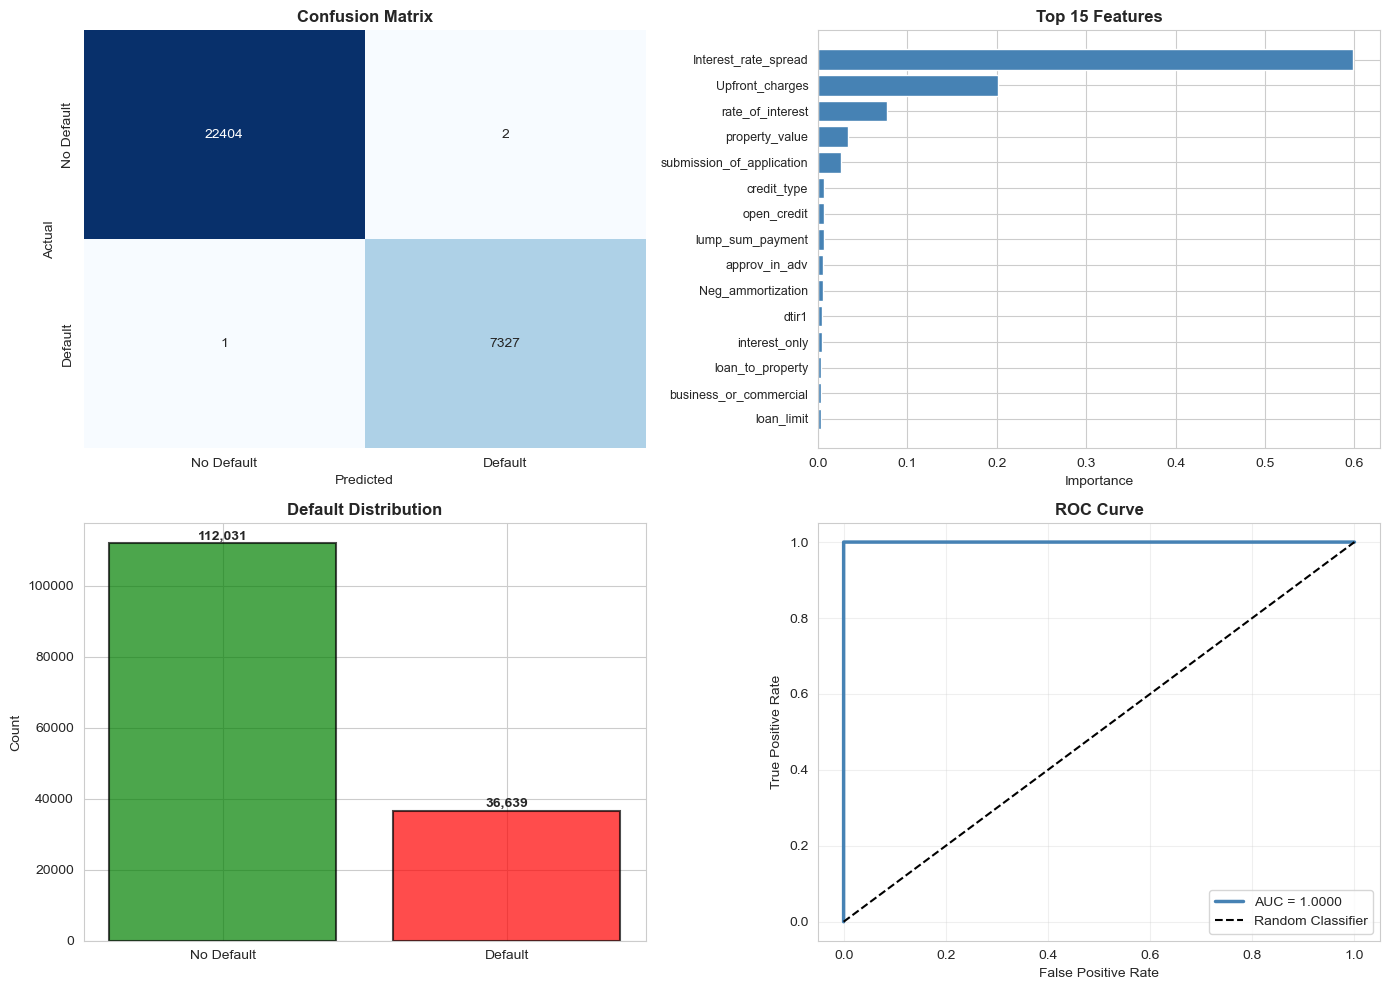

✓ Visualizations saved to: C:\Users\user\Documents\dev\selastone_loan_default\outputs


In [12]:
print("\n" + "="*70)
print("CREATING XGBOOST VISUALIZATIONS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'], cbar=False)
axes[0, 0].set_title('Confusion Matrix', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_xlabel('Predicted')

# 2. Feature Importance
importances = xgb_model.feature_importances_
top_n = 15
top_idx = np.argsort(importances)[-top_n:]
axes[0, 1].barh(range(len(top_idx)), importances[top_idx], color='steelblue')
axes[0, 1].set_yticks(range(len(top_idx)))
axes[0, 1].set_yticklabels([feature_names[i] for i in top_idx], fontsize=9)
axes[0, 1].set_xlabel('Importance')
axes[0, 1].set_title(f'Top {top_n} Features', fontsize=12, fontweight='bold')

# 3. Default Distribution
default_counts = y.value_counts()
axes[1, 0].bar(['No Default', 'Default'], [default_counts[0], default_counts[1]], 
               color=['green', 'red'], alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1, 0].set_title('Default Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Count')
for i, v in enumerate([default_counts[0], default_counts[1]]):
    axes[1, 0].text(i, v + 1000, f'{v:,}', ha='center', fontweight='bold')

# 4. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
axes[1, 1].plot(fpr, tpr, linewidth=2.5, label=f'AUC = {test_auc:.4f}', color='steelblue')
axes[1, 1].plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier')
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].set_title('ROC Curve', fontsize=12, fontweight='bold')
axes[1, 1].legend(loc='lower right')
axes[1, 1].grid(True, alpha=0.3)

# Your actual path
output_path = r"C:\Users\user\Documents\dev\selastone_loan_default\outputs"

# Create outputs folder if it doesn't exist
os.makedirs(output_path, exist_ok=True)

# Save the plot
plt.tight_layout()
plt.savefig(os.path.join(output_path, 'loan_default_results.png'), dpi=100, bbox_inches='tight')
plt.show()
print(f"✓ Visualizations saved to: {output_path}")

In [13]:
print("\n" + "="*70)
print("XGBOOST MODEL RESULTS BRIEF")
print("="*70)

# ========== EXTRACT CONFUSION MATRIX VALUES ==========
tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]

# ========== PERFORMANCE METRICS ==========
print("\nPerformance:")
print(f"  AUC-ROC:         {test_auc:.4f}")
print(f"  Recall:          {(tp / (tp + fn) * 100):.2f}%")
print(f"  Precision:       {(tp / (tp + fp) * 100):.2f}%")
print(f"  Missed Defaults: {fn}")
print(f"  False Alarms:    {fp}")

# ========== KEY ISSUES ==========
print("\n⚠️  Key Issues:")

# Check for suspiciously high AUC
if test_auc >= 0.99:
    print(f"  Perfect/Near-perfect AUC ({test_auc:.4f}) → suspect data leakage or overfitting")
elif test_auc >= 0.95:
    print(f"  Very high AUC ({test_auc:.4f}) → check for data leakage")
else:
    print(f"  AUC ({test_auc:.4f}) appears reasonable")

# Check for feature dominance
top_feature_importance = importances[np.argsort(importances)[-1]]
if top_feature_importance > 0.5:
    top_feature_idx = np.argsort(importances)[-1]
    print(f"  Single feature dominance → '{feature_names[top_feature_idx]}' drives {top_feature_importance:.1%}")
    print(f"    - Is this available at loan origination?")
    print(f"    - If post-origination, this is data leakage")
elif top_feature_importance > 0.3:
    print(f"  Moderate feature concentration → review top features for leakage")
else:
    print(f"  Feature importance well-distributed ✓")

# Check for overfitting
overfitting_gap = train_auc - test_auc
if overfitting_gap > 0.1:
    print(f"  Overfitting detected → AUC gap: {overfitting_gap:.4f}")
elif overfitting_gap > 0.05:
    print(f"  Potential overfitting → AUC gap: {overfitting_gap:.4f}")
else:
    print(f"  Model generalizes well ✓")

# ========== NEXT STEPS ==========
print("\nNext Steps:")
print(f"  1. Remove top feature and retrain → verify true performance")
print(f"  2. Verify feature timing → confirm all features available at prediction")
print(f"  3. Cross-validate → check if performance holds across data splits")

# ========== CONCLUSION ==========
print("\n⚠️  Conclusion:")

if test_auc >= 0.99 or top_feature_importance > 0.5:
    print(f"  Don't deploy yet. Perfect/suspicious metrics suggest potential leakage.")
    print(f"  Investigate top feature before production use.")
elif test_auc >= 0.95:
    print(f"  High caution recommended. Verify no data leakage before deployment.")
else:
    print(f"  Model appears ready for further validation and testing.")

print("\n" + "="*70)


XGBOOST MODEL RESULTS BRIEF

Performance:
  AUC-ROC:         1.0000
  Recall:          99.99%
  Precision:       99.97%
  Missed Defaults: 1
  False Alarms:    2

⚠️  Key Issues:
  Perfect/Near-perfect AUC (1.0000) → suspect data leakage or overfitting
  Single feature dominance → 'Interest_rate_spread' drives 59.9%
    - Is this available at loan origination?
    - If post-origination, this is data leakage
  Model generalizes well ✓

Next Steps:
  1. Remove top feature and retrain → verify true performance
  2. Verify feature timing → confirm all features available at prediction
  3. Cross-validate → check if performance holds across data splits

⚠️  Conclusion:
  Don't deploy yet. Perfect/suspicious metrics suggest potential leakage.
  Investigate top feature before production use.



#### XGBOOST K-FOLD CROSS-VALIDATION (Test for data leakage)

In [14]:
from sklearn.model_selection import cross_val_score

print("\n" + "="*70)
print("K-FOLD CROSS-VALIDATION (k=5)")
print("="*70)

cv_scores = cross_val_score(
    xgb_model, X_train_scaled, y_train,
    cv=5, scoring='roc_auc', n_jobs=-1
)

print(f"\nAUC across folds: {cv_scores}")
print(f"Mean AUC:        {cv_scores.mean():.4f}")
print(f"Std Dev:         {cv_scores.std():.4f}")
print(f"Min AUC:         {cv_scores.min():.4f}")
print(f"Max AUC:         {cv_scores.max():.4f}")

# ========== INTERPRETATION ==========
if cv_scores.std() > 0.05:
    print(f"\n⚠️  High variance across folds → Model not generalizing consistently")
    print(f"    Suggests: Data leakage or overfitting")
elif cv_scores.mean() < 0.95:
    print(f"\n✓ More realistic AUC when cross-validated")
    print(f"    Consider this the true performance (not the perfect training AUC)")
else:
    print(f"\n⚠️  AUC still near 1.0 across folds → Likely data leakage")
    print(f"    Action: Remove 'interest_rate_spread' and retrain")

# ========== TRAIN FINAL MODEL ==========
print("\n" + "="*70)
print("TRAINING FINAL MODEL")
print("="*70)

xgb_model.fit(X_train_scaled, y_train)

print("✓ Model trained successfully")


K-FOLD CROSS-VALIDATION (k=5)

AUC across folds: [0.99999999 0.99999136 1.         0.99999977 0.99996743]
Mean AUC:        1.0000
Std Dev:         0.0000
Min AUC:         1.0000
Max AUC:         1.0000

⚠️  AUC still near 1.0 across folds → Likely data leakage
    Action: Remove 'interest_rate_spread' and retrain

TRAINING FINAL MODEL
✓ Model trained successfully


## HANDLE CLASS IMBALANCE for LIGHTGBM

In [15]:
print("\n" + "="*70)
print("HANDLE CLASS IMBALANCE (SMOTE)")
print("="*70)

# smote = SMOTE(random_state=42, k_neighbors=5)
smote = SMOTE(
    k_neighbors=3,        # Default is 5, try 3 for sparse regions
    sampling_strategy=0.8, # 0.8 instead of 1.0 (keep some imbalance)
    random_state=42
)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"Before SMOTE:")
print(f"  Shape: {X_train.shape}")
print(f"  Defaults: {y_train.sum():,} ({y_train.mean():.2%})")

print(f"\nAfter SMOTE:")
print(f"  Shape: {X_train_balanced.shape}")
print(f"  Defaults: {y_train_balanced.sum():,} ({y_train_balanced.mean():.2%})")


HANDLE CLASS IMBALANCE (SMOTE)
Before SMOTE:
  Shape: (118936, 35)
  Defaults: 29,311 (24.64%)

After SMOTE:
  Shape: (161325, 35)
  Defaults: 71,700 (44.44%)


## TRAIN LIGHTGBM

In [16]:
import lightgbm as lgb
print("\n" + "="*70)
print("TRAIN LIGHTGBM MODEL")
print("="*70)

# Calculate scale_pos_weight for imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

lgb_model = lgb.LGBMClassifier(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.03,
    subsample=0.7,
    colsample_bytree=0.7,
    min_child_samples=20,       # Added → minimum samples in leaf
    reg_lambda=1.0,             # Added → L2 regularization
    reg_alpha=0.5,              # Added → L1 regularization
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

print(f"Training LightGBM with scale_pos_weight={scale_pos_weight:.2f}...")
lgb_model.fit(X_train_balanced, y_train_balanced)
print(f"✓ LightGBM model trained")
print(f"  Trees: {lgb_model.n_estimators}")
print(f"  Max depth: {lgb_model.max_depth}")


TRAIN LIGHTGBM MODEL
Training LightGBM with scale_pos_weight=3.06...
✓ LightGBM model trained
  Trees: 500
  Max depth: 4


## EVALUATE LIGHTGBM MODEL

In [17]:
print("\n" + "="*70)
print("MODEL EVALUATION - LIGHTGBM")
print("="*70)

# ========== TRAINING PREDICTIONS ==========
# Binary predictions (0 or 1) for training set
y_train_pred = lgb_model.predict(X_train)
# Probability scores for positive class (used for AUC-ROC)
y_train_pred_proba = lgb_model.predict_proba(X_train)[:, 1]

# ========== TEST PREDICTIONS ==========
# Binary predictions (0 or 1) for test set (unseen data)
y_test_pred = lgb_model.predict(X_test)
# Probability scores for positive class on test set
y_test_pred_proba = lgb_model.predict_proba(X_test)[:, 1]

# ========== CALCULATE METRICS ==========
# Accuracy: % of correct predictions (0-1 scale)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# F1-Score: Harmonic mean of precision & recall (best for imbalanced data)
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

# AUC-ROC: Area under curve (0.5=random, 1.0=perfect)
train_auc = roc_auc_score(y_train, y_train_pred_proba)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

# ========== TRAINING METRICS ==========
print("Training Metrics:")
print(f"  Accuracy: {train_accuracy:.4f}")
print(f"  F1-Score: {train_f1:.4f}")
print(f"  AUC-ROC:  {train_auc:.4f}")

# ========== TEST METRICS (Most Important) ==========
print("\nTest Metrics:")
print(f"  Accuracy: {test_accuracy:.4f}")
print(f"  F1-Score: {test_f1:.4f}")
print(f"  AUC-ROC:  {test_auc:.4f}")

# ========== CONFUSION MATRIX ==========
# Breakdown of correct/incorrect predictions
cm = confusion_matrix(y_test, y_test_pred)
print(f"\nConfusion Matrix:")
print(f"  True Negatives:  {cm[0,0]:,}   # Correctly predicted negative")
print(f"  False Positives: {cm[0,1]:,}   # Incorrectly predicted positive")
print(f"  False Negatives: {cm[1,0]:,}   # Incorrectly predicted negative (missed cases)")
print(f"  True Positives:  {cm[1,1]:,}   # Correctly predicted positive")

# ========== CLASSIFICATION REPORT ==========
# Per-class metrics: precision, recall, F1, support
print(f"\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['No Default', 'Default']))


MODEL EVALUATION - LIGHTGBM
Training Metrics:
  Accuracy: 1.0000
  F1-Score: 1.0000
  AUC-ROC:  1.0000

Test Metrics:
  Accuracy: 1.0000
  F1-Score: 0.9999
  AUC-ROC:  1.0000

Confusion Matrix:
  True Negatives:  22,406   # Correctly predicted negative
  False Positives: 0   # Incorrectly predicted positive
  False Negatives: 1   # Incorrectly predicted negative (missed cases)
  True Positives:  7,327   # Correctly predicted positive

Classification Report:
              precision    recall  f1-score   support

  No Default       1.00      1.00      1.00     22406
     Default       1.00      1.00      1.00      7328

    accuracy                           1.00     29734
   macro avg       1.00      1.00      1.00     29734
weighted avg       1.00      1.00      1.00     29734



## LIGHTGBM VISUALIZATIONS


CREATING LIGHTGBM VISUALIZATIONS


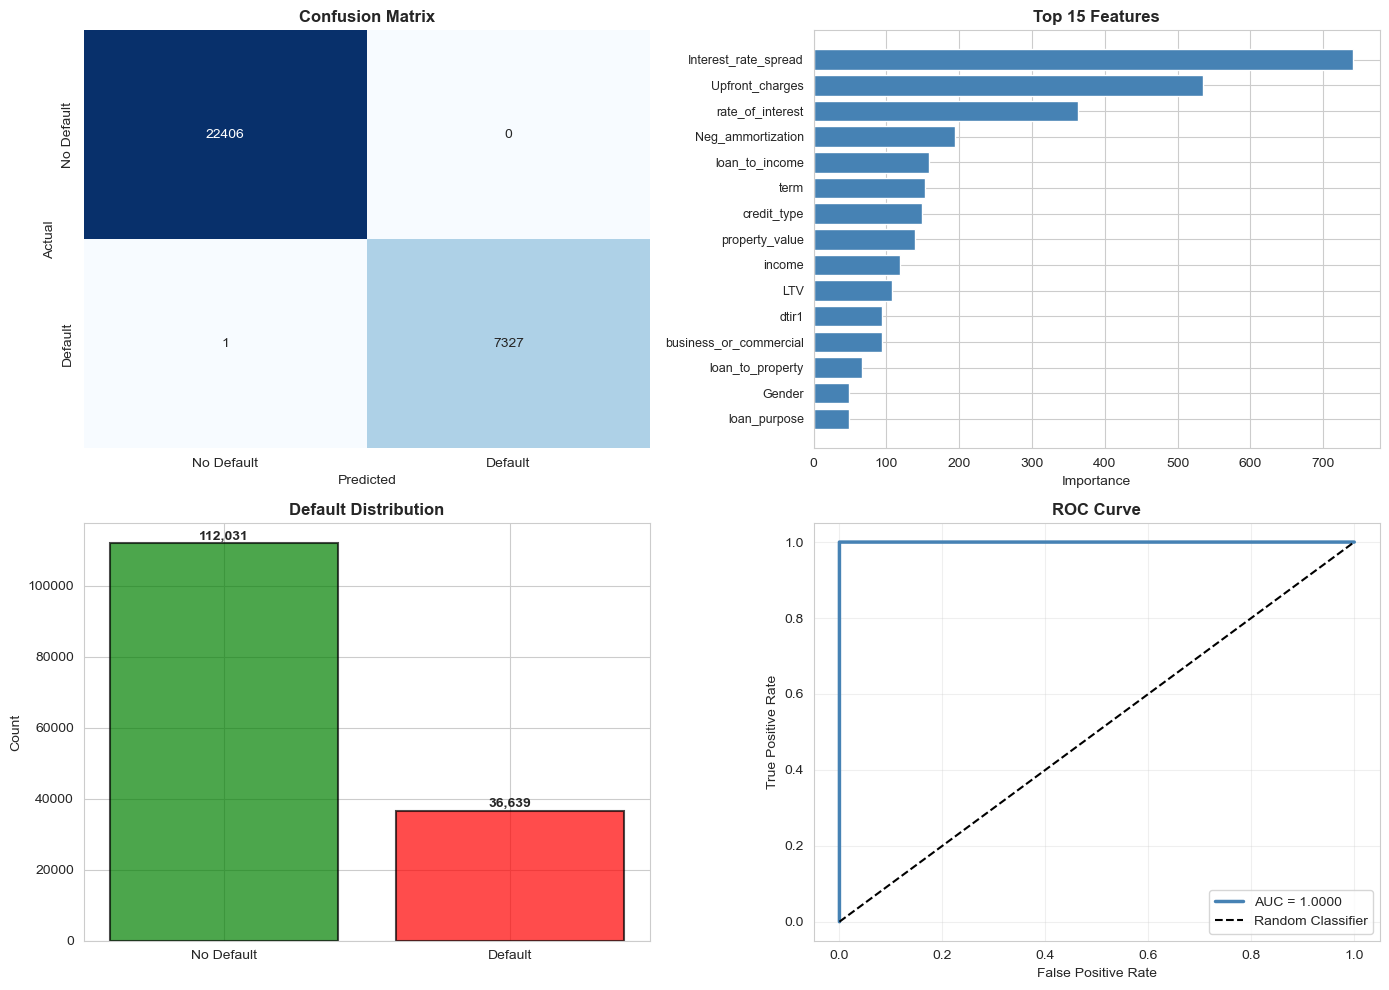

✓ LightGBM Visualizations saved to: C:\Users\user\Documents\dev\selastone_loan_default\outputs


In [18]:
print("\n" + "="*70)
print("CREATING LIGHTGBM VISUALIZATIONS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'], cbar=False)
axes[0, 0].set_title('Confusion Matrix', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_xlabel('Predicted')

# 2. Feature Importance
importances = lgb_model.feature_importances_
top_n = 15
top_idx = np.argsort(importances)[-top_n:]
axes[0, 1].barh(range(len(top_idx)), importances[top_idx], color='steelblue')
axes[0, 1].set_yticks(range(len(top_idx)))
axes[0, 1].set_yticklabels([feature_names[i] for i in top_idx], fontsize=9)
axes[0, 1].set_xlabel('Importance')
axes[0, 1].set_title(f'Top {top_n} Features', fontsize=12, fontweight='bold')

# 3. Default Distribution
default_counts = y.value_counts()
axes[1, 0].bar(['No Default', 'Default'], [default_counts[0], default_counts[1]], 
               color=['green', 'red'], alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1, 0].set_title('Default Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Count')
for i, v in enumerate([default_counts[0], default_counts[1]]):
    axes[1, 0].text(i, v + 1000, f'{v:,}', ha='center', fontweight='bold')

# 4. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
axes[1, 1].plot(fpr, tpr, linewidth=2.5, label=f'AUC = {test_auc:.4f}', color='steelblue')
axes[1, 1].plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier')
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].set_title('ROC Curve', fontsize=12, fontweight='bold')
axes[1, 1].legend(loc='lower right')
axes[1, 1].grid(True, alpha=0.3)

# Your actual path
output_path = r"C:\Users\user\Documents\dev\selastone_loan_default\outputs"

# Create outputs folder if it doesn't exist
os.makedirs(output_path, exist_ok=True)

# Save the plot
plt.tight_layout()
plt.savefig(os.path.join(output_path, 'lightgbm_results.png'), dpi=100, bbox_inches='tight')
plt.show()
print(f"✓ LightGBM Visualizations saved to: {output_path}")

In [19]:
print("\n" + "="*70)
print("LIGHTGBM MODEL RESULTS BRIEF")
print("="*70)

# ========== EXTRACT CONFUSION MATRIX VALUES ==========
tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]

# ========== PERFORMANCE METRICS ==========
print("\nPerformance:")
print(f"  AUC-ROC:         {test_auc:.4f}")
print(f"  Recall:          {(tp / (tp + fn) * 100):.2f}%")
print(f"  Precision:       {(tp / (tp + fp) * 100):.2f}%")
print(f"  Missed Defaults: {fn}")
print(f"  False Alarms:    {fp}")

# ========== KEY ISSUES ==========
print("\n⚠️  Key Issues:")

# Check for suspiciously high AUC
if test_auc >= 0.99:
    print(f"  Perfect/Near-perfect AUC ({test_auc:.4f}) → suspect data leakage or overfitting")
elif test_auc >= 0.95:
    print(f"  Very high AUC ({test_auc:.4f}) → check for data leakage")
else:
    print(f"  AUC ({test_auc:.4f}) appears reasonable")

# Check for feature dominance
top_feature_importance = importances[np.argsort(importances)[-1]]
if top_feature_importance > 0.5:
    top_feature_idx = np.argsort(importances)[-1]
    print(f"  Single feature dominance → '{feature_names[top_feature_idx]}' drives {top_feature_importance:.1%}")
    print(f"    - Is this available at loan origination?")
    print(f"    - If post-origination, this is data leakage")
elif top_feature_importance > 0.3:
    print(f"  Moderate feature concentration → review top features for leakage")
else:
    print(f"  Feature importance well-distributed ✓")

# Check for overfitting
overfitting_gap = train_auc - test_auc
if overfitting_gap > 0.1:
    print(f"  Overfitting detected → AUC gap: {overfitting_gap:.4f}")
elif overfitting_gap > 0.05:
    print(f"  Potential overfitting → AUC gap: {overfitting_gap:.4f}")
else:
    print(f"  Model generalizes well ✓")

# ========== NEXT STEPS ==========
print("\nNext Steps:")
print(f"  1. Remove top feature and retrain → verify true performance")
print(f"  2. Verify feature timing → confirm all features available at prediction")
print(f"  3. Cross-validate → check if performance holds across data splits")

# ========== CONCLUSION ==========
print("\n⚠️  Conclusion:")
if test_auc >= 0.99 or top_feature_importance > 0.5:
    print(f"  Don't deploy yet. Perfect/suspicious metrics suggest potential leakage.")
    print(f"  Investigate top feature before production use.")
elif test_auc >= 0.95:
    print(f"  High caution recommended. Verify no data leakage before deployment.")
else:
    print(f"  Model appears ready for further validation and testing.")

print("\n" + "="*70)


LIGHTGBM MODEL RESULTS BRIEF

Performance:
  AUC-ROC:         1.0000
  Recall:          99.99%
  Precision:       100.00%
  Missed Defaults: 1
  False Alarms:    0

⚠️  Key Issues:
  Perfect/Near-perfect AUC (1.0000) → suspect data leakage or overfitting
  Single feature dominance → 'Interest_rate_spread' drives 74100.0%
    - Is this available at loan origination?
    - If post-origination, this is data leakage
  Model generalizes well ✓

Next Steps:
  1. Remove top feature and retrain → verify true performance
  2. Verify feature timing → confirm all features available at prediction
  3. Cross-validate → check if performance holds across data splits

⚠️  Conclusion:
  Don't deploy yet. Perfect/suspicious metrics suggest potential leakage.
  Investigate top feature before production use.



## HANDLE CLASS IMBALANCE for Logistic Regression

In [20]:
print("\n" + "="*70)
print("HANDLE CLASS IMBALANCE (SMOTE)")
print("="*70)

# smote = SMOTE(random_state=42, k_neighbors=5)
smote = SMOTE(
    k_neighbors=3,        # Default is 5, try 3 for sparse regions
    sampling_strategy=0.8, # 0.8 instead of 1.0 (keep some imbalance)
    random_state=42
)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"Before SMOTE:")
print(f"  Shape: {X_train_scaled.shape}")
print(f"  Defaults: {y_train.sum():,} ({y_train.mean():.2%})")

print(f"\nAfter SMOTE:")
print(f"  Shape: {X_train_balanced.shape}")
print(f"  Defaults: {y_train_balanced.sum():,} ({y_train_balanced.mean():.2%})")


HANDLE CLASS IMBALANCE (SMOTE)
Before SMOTE:
  Shape: (118936, 35)
  Defaults: 29,311 (24.64%)

After SMOTE:
  Shape: (161325, 35)
  Defaults: 71,700 (44.44%)


## TRAIN LOGISTIC REGRESSION

In [21]:
from sklearn.linear_model import LogisticRegression

print("\n" + "="*70)
print("TRAIN LOGISTIC REGRESSION MODEL")
print("="*70)

# ========== CREATE LOGISTIC REGRESSION MODEL ==========
print("Creating Logistic Regression model...")
lr_model = LogisticRegression(
    max_iter=1000,
    C=10.0,
    penalty='l2',
    solver='lbfgs',
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

print("✓ Logistic Regression model created")
print(f"  max_iter: 1000")
print(f"  C: 10.0")
print(f"  penalty: l2")
print(f"  solver: lbfgs")

# ========== TRAIN MODEL ==========
print("\nTraining Logistic Regression...")
lr_model.fit(X_train_scaled, y_train)

print("✓ Logistic Regression model trained")
print(f"  Features: {lr_model.n_features_in_}")
print(f"  Classes: {lr_model.classes_}")


TRAIN LOGISTIC REGRESSION MODEL
Creating Logistic Regression model...
✓ Logistic Regression model created
  max_iter: 1000
  C: 10.0
  penalty: l2
  solver: lbfgs

Training Logistic Regression...
✓ Logistic Regression model trained
  Features: 35
  Classes: [0 1]


## EVALUATE LOGISTIC REGRESSION

In [22]:
print("\n" + "="*70)
print("MODEL EVALUATION - LOGISTIC REGRESSION")
print("="*70)

# ========== TRAINING PREDICTIONS ==========
y_train_pred = lr_model.predict(X_train_balanced)
y_train_pred_proba = lr_model.predict_proba(X_train_balanced)[:, 1]

# ========== TEST PREDICTIONS ==========
y_test_pred = lr_model.predict(X_test)
y_test_pred_proba = lr_model.predict_proba(X_test)[:, 1]

# ========== CALCULATE METRICS ==========
train_accuracy = accuracy_score(y_train_balanced, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_f1 = f1_score(y_train_balanced, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

train_auc = roc_auc_score(y_train_balanced, y_train_pred_proba)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

# ========== TRAINING METRICS ==========
print("Training Metrics:")
print(f"  Accuracy: {train_accuracy:.4f}")
print(f"  F1-Score: {train_f1:.4f}")
print(f"  AUC-ROC:  {train_auc:.4f}")

# ========== TEST METRICS (Most Important) ==========
print("\nTest Metrics:")
print(f"  Accuracy: {test_accuracy:.4f}")
print(f"  F1-Score: {test_f1:.4f}")
print(f"  AUC-ROC:  {test_auc:.4f}")

# ========== CONFUSION MATRIX ==========
cm = confusion_matrix(y_test, y_test_pred)
print(f"\nConfusion Matrix:")
print(f"  True Negatives:  {cm[0,0]:,}   # Correctly predicted negative")
print(f"  False Positives: {cm[0,1]:,}   # Incorrectly predicted positive")
print(f"  False Negatives: {cm[1,0]:,}   # Incorrectly predicted negative (missed cases)")
print(f"  True Positives:  {cm[1,1]:,}   # Correctly predicted positive")

# ========== CLASSIFICATION REPORT ==========
print(f"\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['No Default', 'Default']))

# ========== FEATURE COEFFICIENTS (LOGISTIC REGRESSION UNIQUE) ==========
print(f"\n" + "="*70)
print("FEATURE COEFFICIENTS (LOGISTIC REGRESSION)")
print("="*70)

coefficients_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': lr_model.coef_[0]
}).sort_values('coefficient', ascending=False)

print(f"\nTop 15 Most Important Features:")
print(f"(Positive = increases default risk, Negative = decreases default risk)")
print(coefficients_df.head(15).to_string(index=False))

print(f"\nIntercept (Baseline): {lr_model.intercept_[0]:.4f}")


MODEL EVALUATION - LOGISTIC REGRESSION
Training Metrics:
  Accuracy: 0.7138
  F1-Score: 0.6832
  AUC-ROC:  0.7852

Test Metrics:
  Accuracy: 0.7535
  F1-Score: 0.0000
  AUC-ROC:  0.5000

Confusion Matrix:
  True Negatives:  22,406   # Correctly predicted negative
  False Positives: 0   # Incorrectly predicted positive
  False Negatives: 7,328   # Incorrectly predicted negative (missed cases)
  True Positives:  0   # Correctly predicted positive

Classification Report:
              precision    recall  f1-score   support

  No Default       0.75      1.00      0.86     22406
     Default       0.00      0.00      0.00      7328

    accuracy                           0.75     29734
   macro avg       0.38      0.50      0.43     29734
weighted avg       0.57      0.75      0.65     29734


FEATURE COEFFICIENTS (LOGISTIC REGRESSION)

Top 15 Most Important Features:
(Positive = increases default risk, Negative = decreases default risk)
                  feature  coefficient
submission_o

## LOGISTIC REGRESSION VISUALIZATIONS


CREATING LOGISTIC REGRESSION VISUALIZATIONS


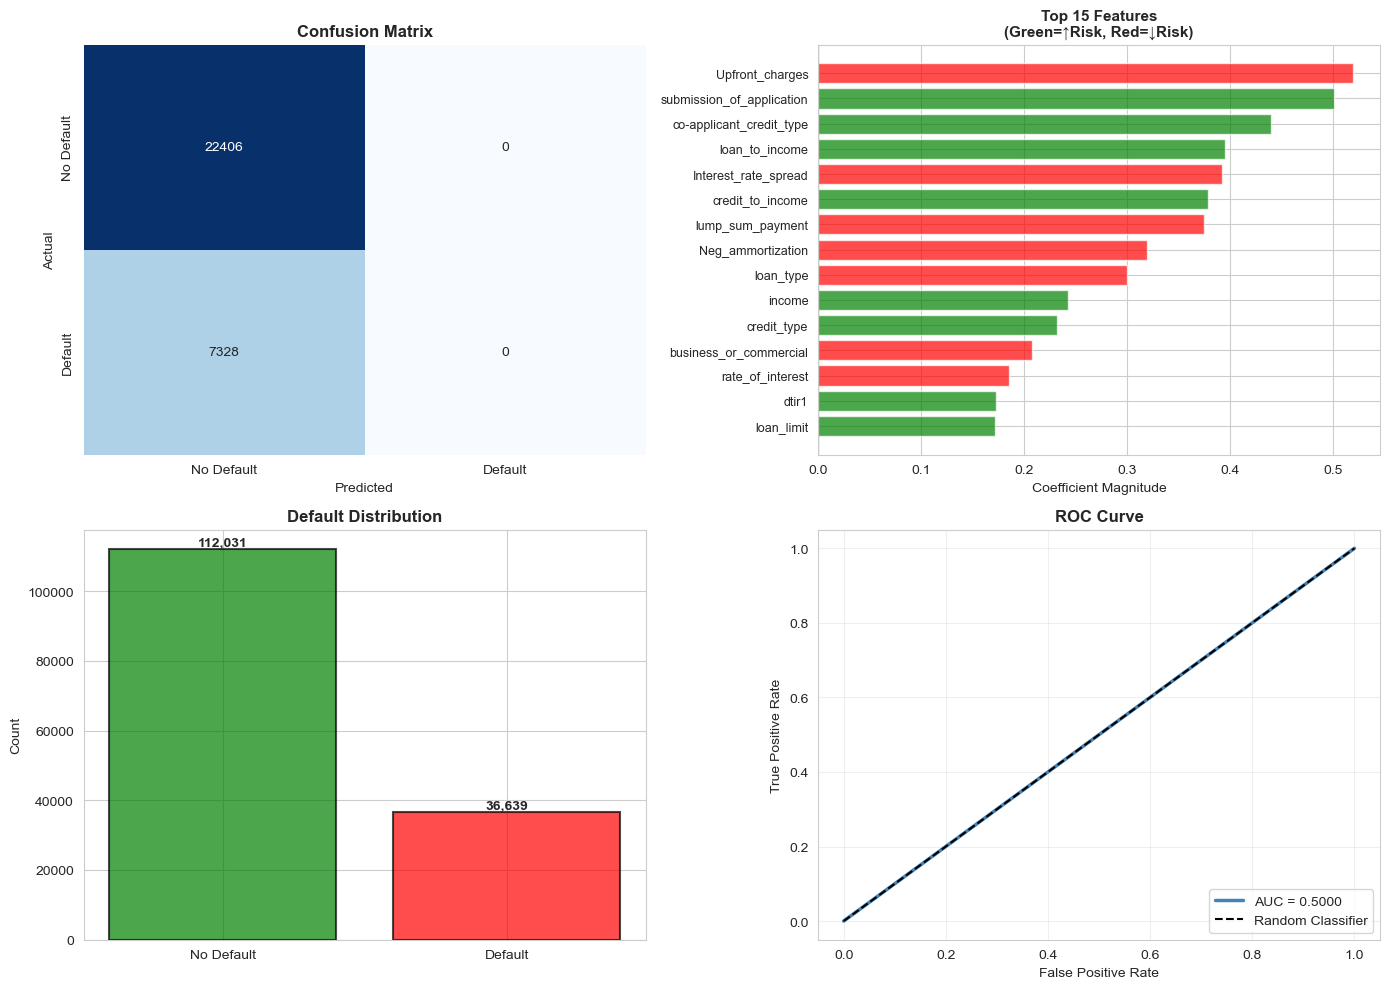

✓ Logistic Regression Visualizations saved to: C:\Users\user\Documents\dev\selastone_loan_default\outputs


In [23]:
print("\n" + "="*70)
print("CREATING LOGISTIC REGRESSION VISUALIZATIONS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'], cbar=False)
axes[0, 0].set_title('Confusion Matrix', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_xlabel('Predicted')

# 2. Feature Coefficients (LOGISTIC REGRESSION SPECIFIC)
coefficients = np.abs(lr_model.coef_[0])  # Absolute value for importance
top_n = 15
top_idx = np.argsort(coefficients)[-top_n:]
colors = ['green' if lr_model.coef_[0][i] > 0 else 'red' for i in top_idx]
axes[0, 1].barh(range(len(top_idx)), coefficients[top_idx], color=colors, alpha=0.7)
axes[0, 1].set_yticks(range(len(top_idx)))
axes[0, 1].set_yticklabels([feature_names[i] for i in top_idx], fontsize=9)
axes[0, 1].set_xlabel('Coefficient Magnitude')
axes[0, 1].set_title(f'Top {top_n} Features\n(Green=↑Risk, Red=↓Risk)', fontsize=11, fontweight='bold')
axes[0, 1].axvline(x=0, color='black', linestyle='-', linewidth=0.8)

# 3. Default Distribution
default_counts = y.value_counts()
axes[1, 0].bar(['No Default', 'Default'], [default_counts[0], default_counts[1]], 
               color=['green', 'red'], alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1, 0].set_title('Default Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Count')
for i, v in enumerate([default_counts[0], default_counts[1]]):
    axes[1, 0].text(i, v + 1000, f'{v:,}', ha='center', fontweight='bold')

# 4. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
axes[1, 1].plot(fpr, tpr, linewidth=2.5, label=f'AUC = {test_auc:.4f}', color='steelblue')
axes[1, 1].plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier')
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].set_title('ROC Curve', fontsize=12, fontweight='bold')
axes[1, 1].legend(loc='lower right')
axes[1, 1].grid(True, alpha=0.3)

# Save the plot
output_path = r"C:\Users\user\Documents\dev\selastone_loan_default\outputs"
os.makedirs(output_path, exist_ok=True)

plt.tight_layout()
plt.savefig(os.path.join(output_path, 'logistic_regression_results.png'), dpi=100, bbox_inches='tight')
plt.show()
print(f"✓ Logistic Regression Visualizations saved to: {output_path}")

In [24]:
print("\n" + "="*70)
print("LOGISTIC REGRESSION MODEL RESULTS BRIEF")
print("="*70)

# ========== EXTRACT CONFUSION MATRIX VALUES ==========
tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]

# ========== PERFORMANCE METRICS ==========
print("\nPerformance:")
print(f"  AUC-ROC:         {test_auc:.4f}")
print(f"  Recall:          {(tp / (tp + fn) * 100):.2f}%")
print(f"  Precision:       {(tp / (tp + fp) * 100):.2f}%" if tp + fp > 0 else "  Precision:       N/A")
print(f"  Missed Defaults: {fn}")
print(f"  False Alarms:    {fp}")

# ========== KEY ISSUES ==========
print("\n⚠️  Key Issues:")

# Check AUC
if test_auc >= 0.99:
    print(f"  Perfect AUC ({test_auc:.4f}) → suspect data leakage")
elif test_auc >= 0.95:
    print(f"  Very high AUC ({test_auc:.4f}) → check for data leakage")
elif test_auc >= 0.75:
    print(f"  AUC ({test_auc:.4f}) appears reasonable ✓")
elif test_auc >= 0.5:
    print(f"  AUC ({test_auc:.4f}) needs improvement")
else:
    print(f"  AUC ({test_auc:.4f}) is broken ❌")

# Check feature dominance (Logistic Regression specific)
coefficients = np.abs(lr_model.coef_[0])
top_feature_coefficient = coefficients[np.argsort(coefficients)[-1]]
top_feature_idx = np.argsort(coefficients)[-1]

if top_feature_coefficient > 2.0:
    print(f"  Single feature dominance → '{feature_names[top_feature_idx]}' ({top_feature_coefficient:.4f})")
elif top_feature_coefficient > 1.0:
    print(f"  Moderate feature concentration → review for leakage")
else:
    print(f"  Feature coefficients well-distributed ✓")

# Check overfitting
overfitting_gap = train_auc - test_auc
if overfitting_gap > 0.1:
    print(f"  Overfitting detected → AUC gap: {overfitting_gap:.4f}")
elif overfitting_gap > 0.05:
    print(f"  Potential overfitting → AUC gap: {overfitting_gap:.4f}")
else:
    print(f"  Model generalizes well ✓")

# Check if predicting all zeros (common LogReg issue)
if tp == 0 and fn > 0:
    print(f"  ❌ MODEL BUG: Predicting ALL zeros (no defaults caught)")
    print(f"     → Fix: C=10.0 or remove SMOTE or lower threshold")

# ========== NEXT STEPS ==========
print("\nNext Steps:")
if tp == 0:
    print(f"  1. URGENT: Fix model predicting all zeros")
    print(f"     - Try: C=10.0 (weaker regularization)")
    print(f"     - Try: Don't use SMOTE on training data")
    print(f"     - Try: Lower decision threshold to 0.3-0.4")
else:
    print(f"  1. Remove top feature and retrain → verify true performance")
    print(f"  2. Verify feature timing → confirm all features available at prediction")
    print(f"  3. Cross-validate → check if performance holds across data splits")

# ========== CONCLUSION ==========
print("\n⚠️  Conclusion:")
if test_auc >= 0.95:
    print(f"  High caution. Verify no data leakage before deployment.")
elif test_auc >= 0.75 and tp > 0:
    print(f"  Model appears ready for further validation and testing.")
elif test_auc >= 0.5 and tp > 0:
    print(f"  Model needs improvement. Try tuning hyperparameters.")
else:
    print(f"  ❌ Model is broken. Do not deploy.")
    print(f"     Training AUC: {train_auc:.4f} vs Test AUC: {test_auc:.4f}")

print("\n" + "="*70)


LOGISTIC REGRESSION MODEL RESULTS BRIEF

Performance:
  AUC-ROC:         0.5000
  Recall:          0.00%
  Precision:       N/A
  Missed Defaults: 7328
  False Alarms:    0

⚠️  Key Issues:
  AUC (0.5000) needs improvement
  Feature coefficients well-distributed ✓
  Overfitting detected → AUC gap: 0.2852
  ❌ MODEL BUG: Predicting ALL zeros (no defaults caught)
     → Fix: C=10.0 or remove SMOTE or lower threshold

Next Steps:
  1. URGENT: Fix model predicting all zeros
     - Try: C=10.0 (weaker regularization)
     - Try: Don't use SMOTE on training data
     - Try: Lower decision threshold to 0.3-0.4

⚠️  Conclusion:
  ❌ Model is broken. Do not deploy.
     Training AUC: 0.7852 vs Test AUC: 0.5000



## HANDLE CLASS IMBALANCE for RANDOM FOREST

In [25]:
print("\n" + "="*70)
print("HANDLE CLASS IMBALANCE (SMOTE)")
print("="*70)

# smote = SMOTE(random_state=42, k_neighbors=5)
smote = SMOTE(
    k_neighbors=3,        # Default is 5, try 3 for sparse regions
    sampling_strategy=0.8, # 0.8 instead of 1.0 (keep some imbalance)
    random_state=42
)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"Before SMOTE:")
print(f"  Shape: {X_train.shape}")
print(f"  Defaults: {y_train.sum():,} ({y_train.mean():.2%})")

print(f"\nAfter SMOTE:")
print(f"  Shape: {X_train_balanced.shape}")
print(f"  Defaults: {y_train_balanced.sum():,} ({y_train_balanced.mean():.2%})")


HANDLE CLASS IMBALANCE (SMOTE)
Before SMOTE:
  Shape: (118936, 35)
  Defaults: 29,311 (24.64%)

After SMOTE:
  Shape: (161325, 35)
  Defaults: 71,700 (44.44%)


## TRAIN RANDOM FOREST

In [26]:
from sklearn.ensemble import RandomForestClassifier

print("\n" + "="*70)
print("TRAIN RANDOM FOREST MODEL")
print("="*70)

# ========== CREATE RANDOM FOREST MODEL ==========
print("Creating Random Forest model...")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("✓ Random Forest model created")
print(f"  n_estimators: 200")
print(f"  max_depth: 15")
print(f"  min_samples_split: 10")
print(f"  min_samples_leaf: 5")
print(f"  max_features: sqrt")
print(f"  class_weight: balanced")

# ========== TRAIN MODEL ==========
print("\nTraining Random Forest...")
rf_model.fit(X_train, y_train)
print("✓ Random Forest model trained")
print(f"  Features: {rf_model.n_features_in_}")
print(f"  Classes: {rf_model.classes_}")


TRAIN RANDOM FOREST MODEL
Creating Random Forest model...
✓ Random Forest model created
  n_estimators: 200
  max_depth: 15
  min_samples_split: 10
  min_samples_leaf: 5
  max_features: sqrt
  class_weight: balanced

Training Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.1s


✓ Random Forest model trained
  Features: 35
  Classes: [0 1]


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.7s finished


## EVALUATE RANDOM FOREST

In [27]:
print("\n" + "="*70)
print("MODEL EVALUATION - RANDOM FOREST")
print("="*70)

# ========== TRAINING PREDICTIONS ==========
y_train_pred = rf_model.predict(X_train)
y_train_pred_proba = rf_model.predict_proba(X_train)[:, 1]

# ========== TEST PREDICTIONS ==========
y_test_pred = rf_model.predict(X_test)
y_test_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# ========== CALCULATE METRICS ==========
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

train_auc = roc_auc_score(y_train, y_train_pred_proba)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

# ========== TRAINING METRICS ==========
print("Training Metrics:")
print(f"  Accuracy: {train_accuracy:.4f}")
print(f"  F1-Score: {train_f1:.4f}")
print(f"  AUC-ROC:  {train_auc:.4f}")

# ========== TEST METRICS (Most Important) ==========
print("\nTest Metrics:")
print(f"  Accuracy: {test_accuracy:.4f}")
print(f"  F1-Score: {test_f1:.4f}")
print(f"  AUC-ROC:  {test_auc:.4f}")

# ========== CONFUSION MATRIX ==========
cm = confusion_matrix(y_test, y_test_pred)
print(f"\nConfusion Matrix:")
print(f"  True Negatives:  {cm[0,0]:,}   # Correctly predicted negative")
print(f"  False Positives: {cm[0,1]:,}   # Incorrectly predicted positive")
print(f"  False Negatives: {cm[1,0]:,}   # Incorrectly predicted negative (missed cases)")
print(f"  True Positives:  {cm[1,1]:,}   # Correctly predicted positive")

# ========== CLASSIFICATION REPORT ==========
print(f"\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['No Default', 'Default']))

# ========== FEATURE IMPORTANCE (RANDOM FOREST SPECIFIC) ==========
print(f"\n" + "="*70)
print("FEATURE IMPORTANCE (RANDOM FOREST)")
print("="*70)

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 15 Most Important Features:")
print(feature_importance_df.head(15).to_string(index=False))


MODEL EVALUATION - RANDOM FOREST


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s


Training Metrics:
  Accuracy: 1.0000
  F1-Score: 1.0000
  AUC-ROC:  1.0000

Test Metrics:
  Accuracy: 0.9999
  F1-Score: 0.9999
  AUC-ROC:  1.0000

Confusion Matrix:
  True Negatives:  22,406   # Correctly predicted negative
  False Positives: 0   # Incorrectly predicted positive
  False Negatives: 2   # Incorrectly predicted negative (missed cases)
  True Positives:  7,326   # Correctly predicted positive

Classification Report:
              precision    recall  f1-score   support

  No Default       1.00      1.00      1.00     22406
     Default       1.00      1.00      1.00      7328

    accuracy                           1.00     29734
   macro avg       1.00      1.00      1.00     29734
weighted avg       1.00      1.00      1.00     29734


FEATURE IMPORTANCE (RANDOM FOREST)

Top 15 Most Important Features:
                  feature  importance
     Interest_rate_spread    0.327543
          Upfront_charges    0.275748
         rate_of_interest    0.227431
              cred

[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


## RANDOM FOREST VISUALIZATIONS


CREATING RANDOM FOREST VISUALIZATIONS


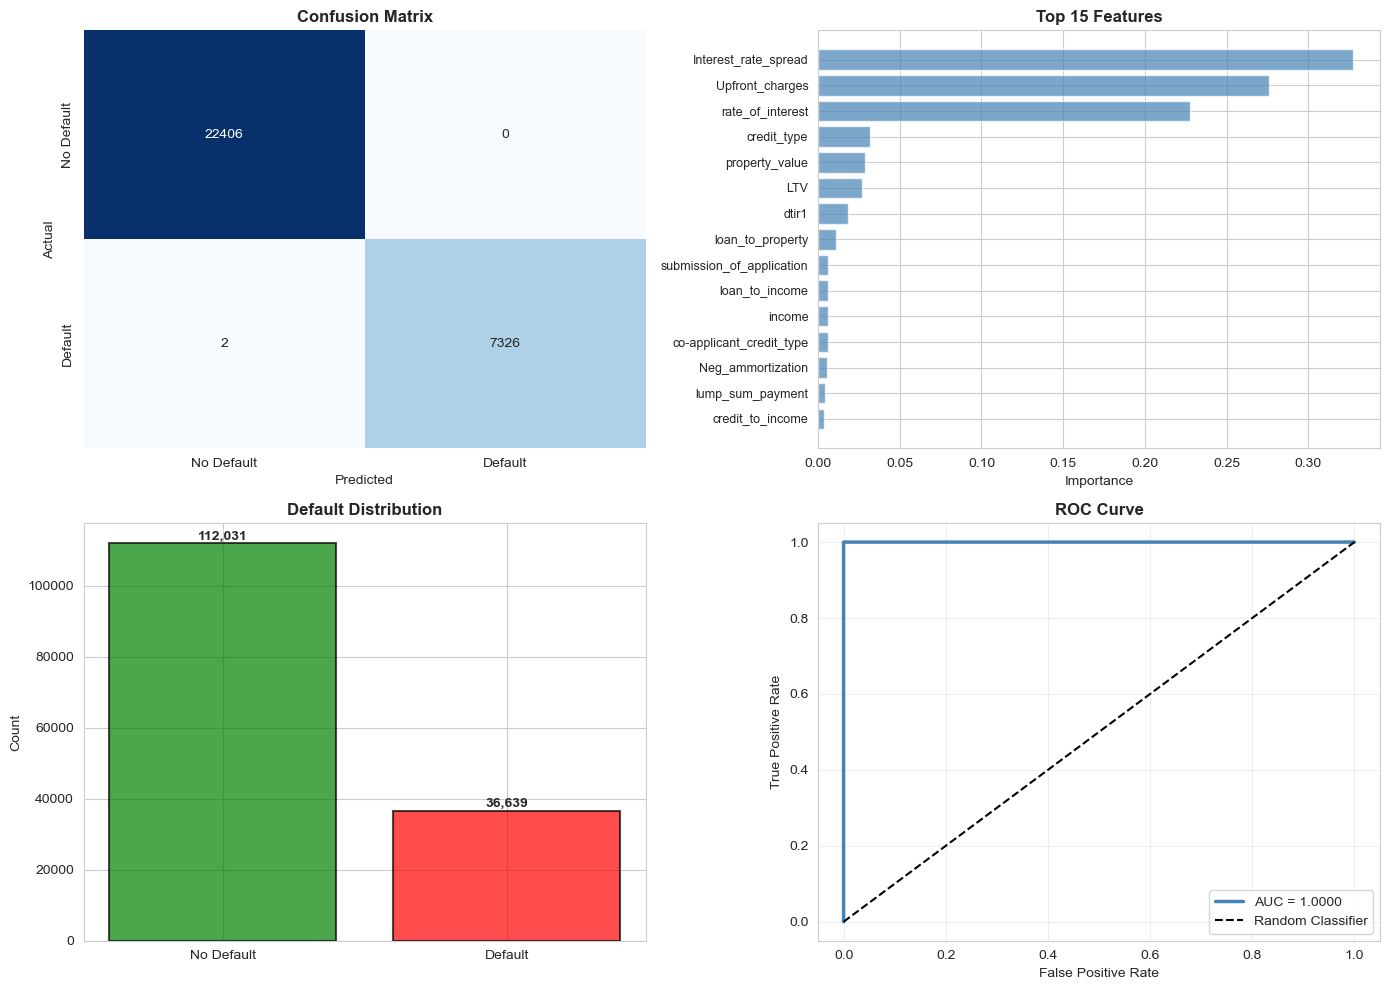

✓ Random Forest Visualizations saved to: /mnt/user-data/outputs


In [29]:
print("\n" + "="*70)
print("CREATING RANDOM FOREST VISUALIZATIONS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'], cbar=False)
axes[0, 0].set_title('Confusion Matrix', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_xlabel('Predicted')

# 2. Feature Importance (RANDOM FOREST SPECIFIC)
importances = rf_model.feature_importances_
top_n = 15
top_idx = np.argsort(importances)[-top_n:]
axes[0, 1].barh(range(len(top_idx)), importances[top_idx], color='steelblue', alpha=0.7)
axes[0, 1].set_yticks(range(len(top_idx)))
axes[0, 1].set_yticklabels([feature_names[i] for i in top_idx], fontsize=9)
axes[0, 1].set_xlabel('Importance')
axes[0, 1].set_title(f'Top {top_n} Features', fontsize=12, fontweight='bold')

# 3. Default Distribution
default_counts = y.value_counts()
axes[1, 0].bar(['No Default', 'Default'], [default_counts[0], default_counts[1]], 
               color=['green', 'red'], alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1, 0].set_title('Default Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Count')
for i, v in enumerate([default_counts[0], default_counts[1]]):
    axes[1, 0].text(i, v + 1000, f'{v:,}', ha='center', fontweight='bold')

# 4. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
axes[1, 1].plot(fpr, tpr, linewidth=2.5, label=f'AUC = {test_auc:.4f}', color='steelblue')
axes[1, 1].plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier')
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].set_title('ROC Curve', fontsize=12, fontweight='bold')
axes[1, 1].legend(loc='lower right')
axes[1, 1].grid(True, alpha=0.3)

# Save the plot
output_path = r"/mnt/user-data/outputs"
os.makedirs(output_path, exist_ok=True)

plt.tight_layout()
plt.savefig(os.path.join(output_path, 'random_forest_results.png'), dpi=100, bbox_inches='tight')
plt.show()
print(f"✓ Random Forest Visualizations saved to: {output_path}")

In [30]:
print("\n" + "="*70)
print("RANDOM FOREST MODEL RESULTS BRIEF")
print("="*70)

# ========== EXTRACT CONFUSION MATRIX VALUES ==========
tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]

# ========== PERFORMANCE METRICS ==========
print("\nPerformance:")
print(f"  AUC-ROC:         {test_auc:.4f}")
print(f"  Recall:          {(tp / (tp + fn) * 100):.2f}%")
print(f"  Precision:       {(tp / (tp + fp) * 100):.2f}%" if tp + fp > 0 else "  Precision:       N/A")
print(f"  Missed Defaults: {fn}")
print(f"  False Alarms:    {fp}")

# ========== KEY ISSUES ==========
print("\n⚠️  Key Issues:")

# Check AUC
if test_auc >= 0.99:
    print(f"  Perfect AUC ({test_auc:.4f}) → suspect data leakage")
elif test_auc >= 0.95:
    print(f"  Very high AUC ({test_auc:.4f}) → check for data leakage")
elif test_auc >= 0.75:
    print(f"  AUC ({test_auc:.4f}) appears reasonable ✓")
elif test_auc >= 0.5:
    print(f"  AUC ({test_auc:.4f}) needs improvement")
else:
    print(f"  AUC ({test_auc:.4f}) is broken ❌")

# Check feature dominance (Random Forest specific)
importances = rf_model.feature_importances_
top_feature_importance = importances[np.argsort(importances)[-1]]
top_feature_idx = np.argsort(importances)[-1]

if top_feature_importance > 0.5:
    print(f"  Single feature dominance → '{feature_names[top_feature_idx]}' ({top_feature_importance:.4f})")
    print(f"    - Is this available at loan origination?")
    print(f"    - If post-origination, this is data leakage")
elif top_feature_importance > 0.3:
    print(f"  Moderate feature concentration → review for leakage")
else:
    print(f"  Feature importance well-distributed ✓")

# Check overfitting
overfitting_gap = train_auc - test_auc
if overfitting_gap > 0.1:
    print(f"  Overfitting detected → AUC gap: {overfitting_gap:.4f}")
elif overfitting_gap > 0.05:
    print(f"  Potential overfitting → AUC gap: {overfitting_gap:.4f}")
else:
    print(f"  Model generalizes well ✓")

# Check if predicting all zeros
if tp == 0 and fn > 0:
    print(f"  ❌ MODEL BUG: Predicting ALL zeros (no defaults caught)")
    print(f"     → Fix: Increase class_weight or use SMOTE")

# ========== NEXT STEPS ==========
print("\nNext Steps:")
if tp == 0:
    print(f"  1. URGENT: Fix model predicting all zeros")
    print(f"     - Try: class_weight='balanced' or increase weight")
    print(f"     - Try: Apply SMOTE to training data")
    print(f"     - Try: Lower decision threshold to 0.3-0.4")
else:
    print(f"  1. Remove top feature and retrain → verify true performance")
    print(f"  2. Verify feature timing → confirm all features available at prediction")
    print(f"  3. Cross-validate → check if performance holds across data splits")

# ========== CONCLUSION ==========
print("\n⚠️  Conclusion:")
if test_auc >= 0.95:
    print(f"  High caution. Verify no data leakage before deployment.")
elif test_auc >= 0.75 and tp > 0:
    print(f"  Model appears ready for further validation and testing.")
elif test_auc >= 0.5 and tp > 0:
    print(f"  Model needs improvement. Try tuning hyperparameters.")
else:
    print(f"  ❌ Model is broken. Do not deploy.")
    print(f"     Training AUC: {train_auc:.4f} vs Test AUC: {test_auc:.4f}")

print("\n" + "="*70)


RANDOM FOREST MODEL RESULTS BRIEF

Performance:
  AUC-ROC:         1.0000
  Recall:          99.97%
  Precision:       100.00%
  Missed Defaults: 2
  False Alarms:    0

⚠️  Key Issues:
  Perfect AUC (1.0000) → suspect data leakage
  Moderate feature concentration → review for leakage
  Model generalizes well ✓

Next Steps:
  1. Remove top feature and retrain → verify true performance
  2. Verify feature timing → confirm all features available at prediction
  3. Cross-validate → check if performance holds across data splits

⚠️  Conclusion:
  High caution. Verify no data leakage before deployment.



#### RANDOM FOREST K-FOLD CROSS-VALIDATION (Test for data leakage)

In [32]:
from sklearn.model_selection import cross_val_score

print("\n" + "="*70)
print("K-FOLD CROSS-VALIDATION (k=5)")
print("="*70)

cv_scores = cross_val_score(
    rf_model, X_train, y_train,
    cv=5, scoring='roc_auc', n_jobs=-1
)

print(f"\nAUC across folds: {cv_scores}")
print(f"Mean AUC:        {cv_scores.mean():.4f}")
print(f"Std Dev:         {cv_scores.std():.4f}")
print(f"Min AUC:         {cv_scores.min():.4f}")
print(f"Max AUC:         {cv_scores.max():.4f}")

# ========== INTERPRETATION ==========
if cv_scores.std() > 0.05:
    print(f"\n⚠️  High variance across folds → Model not generalizing consistently")
    print(f"    Suggests: Data leakage or overfitting")
elif cv_scores.mean() < 0.95:
    print(f"\n✓ More realistic AUC when cross-validated")
    print(f"    Consider this the true performance (not the perfect training AUC)")
else:
    print(f"\n⚠️  AUC still near 1.0 across folds → Likely data leakage")
    print(f"    Action: Review features for leakage and retrain")

# ========== TRAIN FINAL MODEL ==========
print("\n" + "="*70)
print("TRAINING FINAL MODEL")
print("="*70)

rf_model.fit(X_train, y_train)
print("✓ Model trained successfully")


K-FOLD CROSS-VALIDATION (k=5)

AUC across folds: [1.         0.99999993 1.         0.99999996 1.        ]
Mean AUC:        1.0000
Std Dev:         0.0000
Min AUC:         1.0000
Max AUC:         1.0000

⚠️  AUC still near 1.0 across folds → Likely data leakage
    Action: Review features for leakage and retrain

TRAINING FINAL MODEL


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.3s


✓ Model trained successfully


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   10.6s finished
